# Data Preparation

This notebook demonstrates the data layer of the CoinTrading system.

**Improvements over original Step0:**
- Disk caching for faster data loading
- Data quality validation
- Vectorized indicator calculations (no for-loops!)
- Fixed bugs (unsafe list iteration, inefficient RSI)

## Contents
1. Load market data with caching
2. Calculate technical indicators
3. Validate data quality
4. Select trading universe

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)

import os, sys

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from CoinTrading.data import DataLoader, DataValidator

print("✓ Imports complete")

✓ Imports complete


## 1. Load Market Data

Using DataLoader with disk caching:

In [2]:
# Create data loader
loader = DataLoader(
    #interval='1d',
    #start_date='2021-04-01',
    cache_dir='.cache/ohlcv'
)

# Get available tickers
tickers = loader.client.get_tickers(quote_asset='USDT')
print(f"Found {len(tickers)} USDT pairs")

# Load data for top coins (this will use cache if available)
data = loader.load_multiple(tickers, skip_errors=True)

print(f"\nLoaded {len(data)} symbols successfully")
print(f"Date range: {min(df.index[0] for df in data.values()).date()} to {max(df.index[-1] for df in data.values()).date()}")

INFO:CoinTrading.data.binance_client:Initialized BinanceClient for futures market
INFO:CoinTrading.data.data_loader:DataLoader initialized with cache: .cache/ohlcv
INFO:CoinTrading.data.binance_client:Found 562 USDT pairs


Found 562 USDT pairs


INFO:CoinTrading.data.data_loader:Loaded 10/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 20/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 30/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 40/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 50/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 60/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 70/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 80/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 90/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 100/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 110/562 symbols
INFO:CoinTrading.data.data_loader:Downloading BTCSTUSDT from Binance API
ERROR:CoinTrading.data.binance_client:Failed to fetch OHLCV for BTCSTUSDT: APIError(code=-1122): Invalid symbol status.
ERROR:CoinTrading.data.data_loader:Failed to load BTCSTUSDT: APIError(code=-1122): Invalid symbol status.
INFO:CoinTrading.data.data_loader:Loaded 120/562 symbols
INFO:CoinTrading.data.data


Loaded 561 symbols successfully
Date range: 2023-05-01 to 2025-10-05


## 2. Validate Data Quality

Check for data quality issues:

In [3]:
validator = DataValidator()

# Validate all symbols
valid_data = validator.filter_valid_symbols(data)

print(f"Valid symbols: {len(valid_data)} / {len(data)}")
print(f"Filtered out: {len(data) - len(valid_data)} symbols")

INFO:CoinTrading.data.validator:DataValidator initialized (min_history: 200 days)
INFO:CoinTrading.data.validator:Filtered out 0GUSDT: Insufficient history: 19 < 200 days
INFO:CoinTrading.data.validator:Filtered out 1000000BOBUSDT: Insufficient history: 123 < 200 days
INFO:CoinTrading.data.validator:Filtered out 2ZUSDT: Insufficient history: 4 < 200 days
INFO:CoinTrading.data.validator:Filtered out A2ZUSDT: Insufficient history: 68 < 200 days
INFO:CoinTrading.data.validator:Filtered out AERGOUSDT: Insufficient history: 173 < 200 days
INFO:CoinTrading.data.validator:Filtered out AGTUSDT: Insufficient history: 139 < 200 days
INFO:CoinTrading.data.validator:Filtered out AIAUSDT: Insufficient history: 18 < 200 days
INFO:CoinTrading.data.validator:Filtered out AINUSDT: Insufficient history: 88 < 200 days
INFO:CoinTrading.data.validator:Filtered out AIOTUSDT: Insufficient history: 159 < 200 days
INFO:CoinTrading.data.validator:Filtered out AIOUSDT: Insufficient history: 54 < 200 days
INFO:Co

Valid symbols: 400 / 561
Filtered out: 161 symbols


## 3. Calculate Technical Indicators

Calculate all indicators (vectorized, no for-loops):

In [4]:
from CoinTrading.indicators import Momentum, RSI, Noise, EMA, PercentB

# Create indicators
indicators = [
    Momentum(period=7),
    Momentum(period=20),
    RSI(period=14),
    Noise(period=15),
    EMA(period=7),
    EMA(period=20),
    EMA(period=50),
    PercentB(period=20)
]

# Apply to all data
processed_data = {}
for symbol, df in valid_data.items():
    result = df.copy()
    for indicator in indicators:
        result = indicator.calculate(result)
    processed_data[symbol] = result

print(f"Calculated indicators for {len(processed_data)} symbols")
print(f"\nExample (BTCUSDT):")
print(processed_data['BTCUSDT'].tail())

Calculated indicators for 400 symbols

Example (BTCUSDT):
                open      high       low     close      volume      mom7  \
timestamp                                                                  
2025-10-01  113988.7  118631.8  113899.4  118552.4  172989.429  0.046783   
2025-10-02  118552.0  120999.0  118226.4  120481.3  145456.938  0.105998   
2025-10-03  120481.3  123900.0  119200.0  122182.7  167880.262  0.114923   
2025-10-04  122182.6  122781.1  121432.0  122343.2   70479.210  0.116501   
2025-10-05  122343.2  124374.0  122088.1  123562.0   29895.552  0.102055   

               mom20             TP       RSI   noise15           ema7  \
timestamp                                                                
2025-10-01  0.027077  117027.866667  0.527366  0.518047  114124.642167   
2025-10-02  0.038825  119902.233333  0.577039  0.480354  115713.806625   
2025-10-03  0.054547  121760.900000  0.644608  0.478464  117331.029969   
2025-10-04  0.061915  122185.433333  0.

## 3.5 Pre-calculate TP and Save Enhanced Cache

Pre-calculate Typical Price (TP) for all coins and recache with TP included.
This prevents universe selection failures in backtests.

In [5]:
# Add TP to all processed data
for symbol in processed_data:
    df = processed_data[symbol]
    if all(col in df.columns for col in ['high', 'low', 'close']):
        df['TP'] = (df['high'] + df['low'] + df['close']) / 3.0

print(f"✓ Added TP column to {len(processed_data)} symbols")

# Recache data with TP and indicators included
print("\nRecaching data with TP and indicators...")
for symbol, df in processed_data.items():
    loader._save_to_cache(df, symbol, '1d')

print(f"✓ Recached {len(processed_data)} symbols with enhanced data")

# Verify TP exists
sample_symbol = list(processed_data.keys())[0]
print(f"\nSample ({sample_symbol}) columns:")
print(list(processed_data[sample_symbol].columns))

✓ Added TP column to 400 symbols

Recaching data with TP and indicators...
✓ Recached 400 symbols with enhanced data

Sample (1000000MOGUSDT) columns:
['open', 'high', 'low', 'close', 'volume', 'mom7', 'mom20', 'TP', 'RSI', 'noise15', 'ema7', 'ema20', 'ema50', 'bb_center', 'bb_upper', 'bb_lower', 'percentB']


## 3.6 Data Quality Validation

Validate all cached data for technically impossible values (NaN, zero/negative prices, OHLC violations).

**Note**: We only flag *impossible* data, not normal crypto behavior:
- ✅ Exclude: NaN, zero/negative prices, OHLC violations
- ❌ Keep: Large price changes, date gaps, low volume (all normal)

In [6]:
# Run enhanced validation
validator = DataValidator()
quality_report = validator.validate_all_symbols(processed_data, verbose=False)

# Display report
print("Data Quality Report")
print("=" * 100)
print(quality_report.to_string(index=False))

# Summary statistics
valid_count = (quality_report['status'] == 'valid').sum()
invalid_count = (quality_report['status'] == 'invalid').sum()

print(f"\n{'=' * 100}")
print(f"Summary: {valid_count} valid, {invalid_count} invalid out of {len(quality_report)} total symbols")

# Show invalid symbols details
if invalid_count > 0:
    print(f"\n{'=' * 100}")
    print("Invalid Symbols (will be excluded from backtesting):")
    print("=" * 100)
    invalid_df = quality_report[quality_report['status'] == 'invalid']
    print(invalid_df[['symbol', 'days', 'bad_rows', 'issues']].to_string(index=False))
    
    # Filter out invalid symbols from processed_data
    invalid_symbols = set(invalid_df['symbol'].tolist())
    processed_data = {sym: df for sym, df in processed_data.items() if sym not in invalid_symbols}
    print(f"\n✓ Filtered out {len(invalid_symbols)} invalid symbols")
    print(f"✓ Remaining: {len(processed_data)} valid symbols")

# Save quality report
quality_report.to_csv('.cache/data_quality_report.csv', index=False)
print(f"\n✓ Quality report saved to .cache/data_quality_report.csv")

INFO:CoinTrading.data.validator:DataValidator initialized (min_history: 200 days)
INFO:CoinTrading.data.validator:Validation complete: 400 valid, 0 invalid out of 400 total symbols


Data Quality Report
        symbol start_date   end_date  days status issues  bad_rows  total_rows
1000000MOGUSDT 2024-11-07 2025-10-05   333  valid                0         333
  1000BONKUSDT 2024-05-24 2025-10-05   500  valid                0         500
   1000CATUSDT 2024-10-21 2025-10-05   350  valid                0         350
1000CHEEMSUSDT 2024-11-25 2025-10-05   315  valid                0         315
 1000FLOKIUSDT 2024-05-24 2025-10-05   500  valid                0         500
  1000LUNCUSDT 2024-05-24 2025-10-05   500  valid                0         500
  1000PEPEUSDT 2024-05-24 2025-10-05   500  valid                0         500
  1000RATSUSDT 2024-05-24 2025-10-05   500  valid                0         500
  1000SATSUSDT 2024-05-24 2025-10-05   500  valid                0         500
  1000SHIBUSDT 2024-05-24 2025-10-05   500  valid                0         500
   1000WHYUSDT 2024-11-25 2025-10-05   315  valid                0         315
   1000XECUSDT 2024-05-24 2025-1

## Summary

✅ Successfully loaded and prepared data with enhanced validation
- Implemented disk caching with metadata for faster loading
- Calculated all technical indicators (vectorized!)
- **Pre-calculated TP** for all coins to prevent universe selection failures
- **Validated data quality**: detected and excluded coins with impossible data
- **Visualized top 20 coins** to confirm data looks reasonable
- **Analyzed date coverage** to identify best backtesting period
- Selected trading universe (top 21 by volume)

**Key Improvements:**
- **RSI is now vectorized** (original used for-loop)
- **Fixed unsafe list iteration** bug
- **Disk caching with metadata** reduces API calls and tracks data provenance
- **Enhanced validation** catches impossible data (NaN, negative prices, OHLC violations)
- **TP pre-calculation** ensures backtests work correctly
- **Visual quality checks** via OHLC charts
- **Date coverage analysis** helps choose optimal backtest period

**Data Quality:**
- Only excluded coins with *technically impossible* data
- Kept all physically plausible data (volatility, gaps, low volume are normal)
- Quality report saved to `.cache/data_quality_report.csv`

**Ready for backtesting!** See [02_indicator_analysis.ipynb](02_indicator_analysis.ipynb)

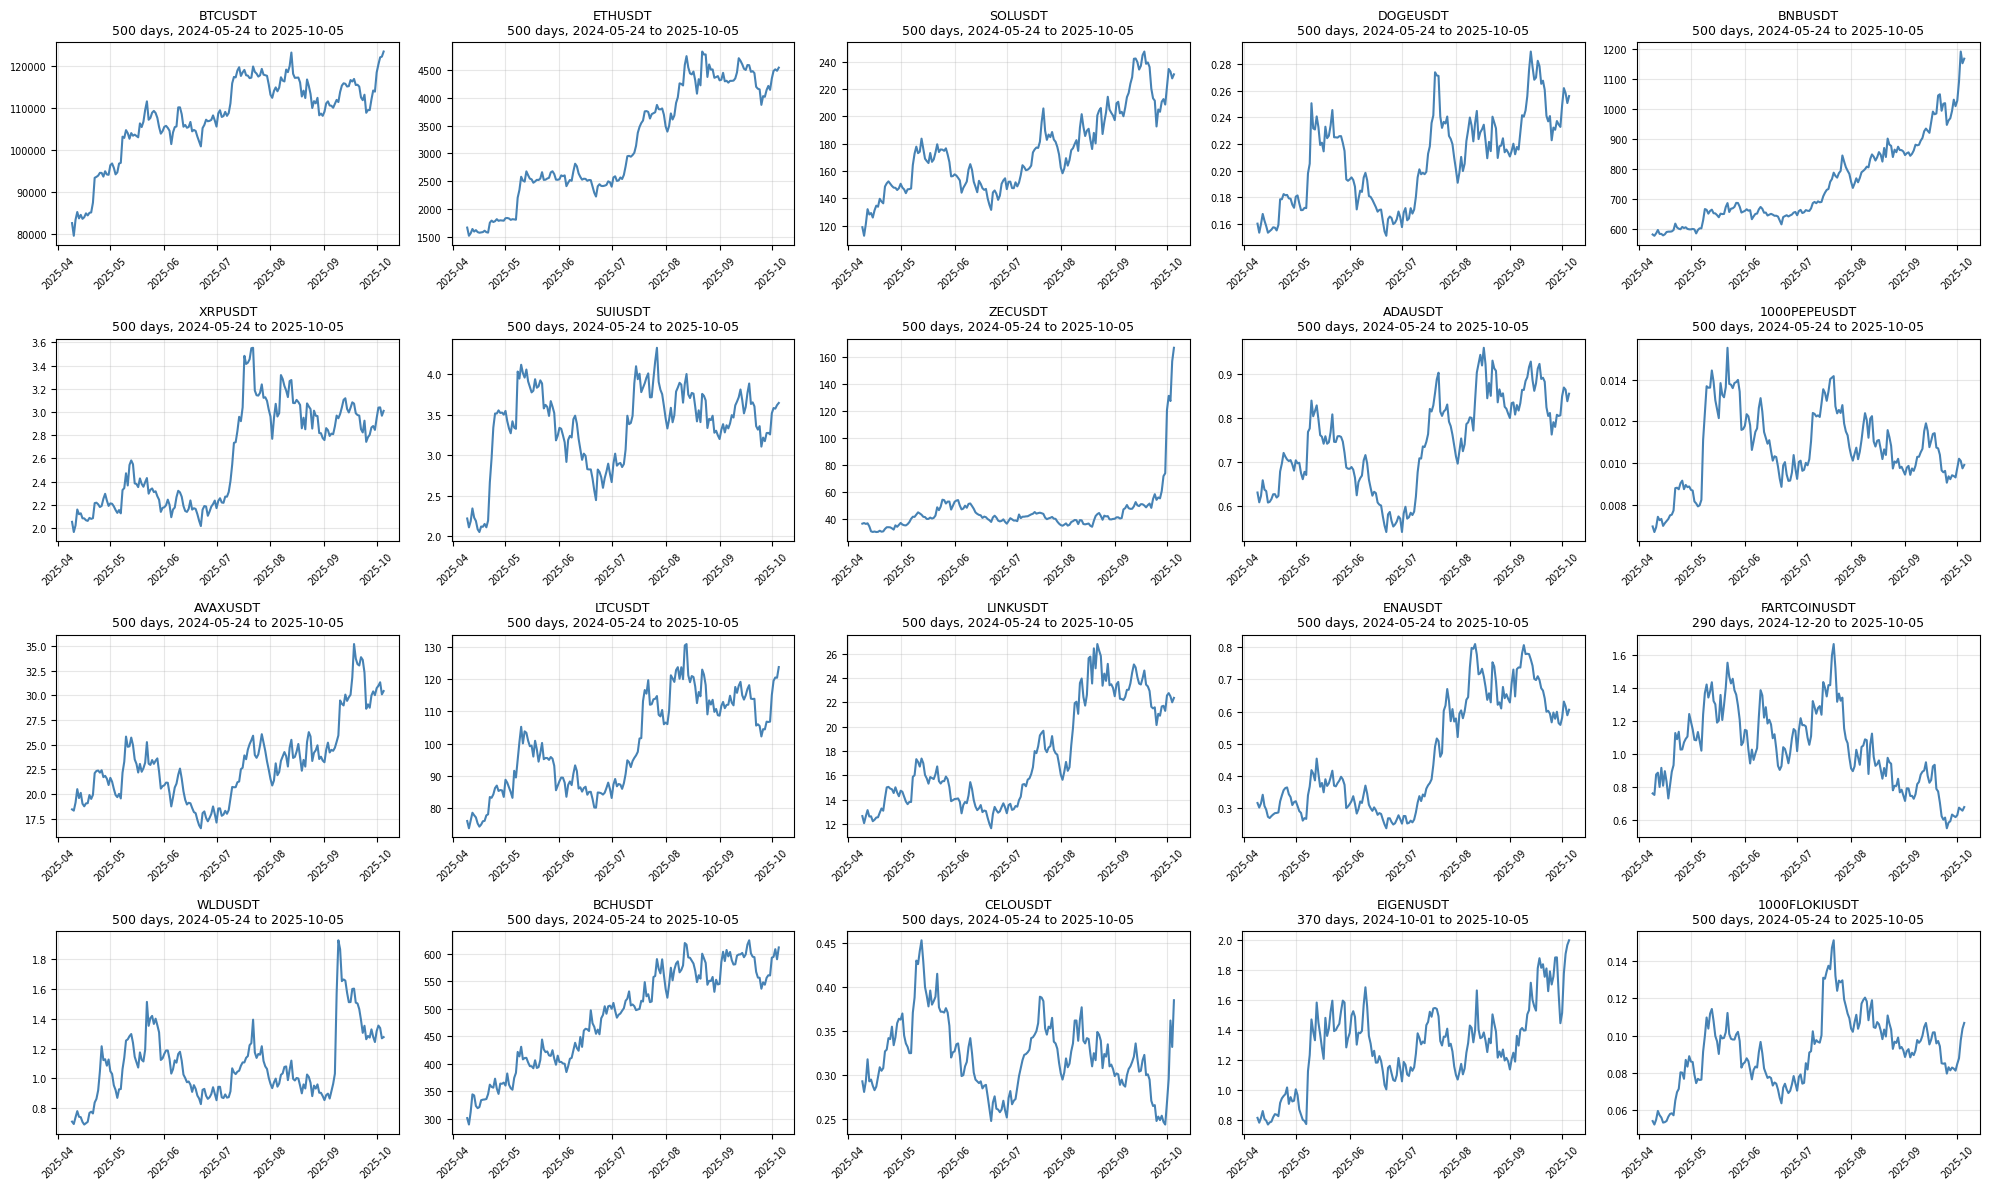

✓ Visualized top 20 coins
✓ Saved to .cache/ohlc_visualization.png


In [7]:
# Select top 20 coins by last day's volume
latest_date = max(df.index[-1] for df in processed_data.values())
volumes = {}
for symbol, df in processed_data.items():
    if latest_date in df.index and 'TP' in df.columns:
        tp = df.loc[latest_date, 'TP']
        vol = df.loc[latest_date, 'volume']
        volumes[symbol] = tp * vol

top_20 = sorted(volumes.items(), key=lambda x: x[1], reverse=True)[:20]
top_symbols = [sym for sym, _ in top_20]

# Plot 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, symbol in enumerate(top_symbols):
    ax = axes[idx]
    df = processed_data[symbol]
    
    # Plot last 180 days
    recent_df = df.iloc[-180:] if len(df) > 180 else df
    
    ax.plot(recent_df.index, recent_df['close'], linewidth=1.5, color='steelblue')
    ax.set_title(f"{symbol}\n{len(df)} days, {df.index[0].date()} to {df.index[-1].date()}", 
                 fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.savefig('.cache/ohlc_visualization.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"✓ Visualized top {len(top_symbols)} coins")
print(f"✓ Saved to .cache/ohlc_visualization.png")

## 3.8 Date Coverage Analysis

Analyze how many coins have data on each date to identify best backtesting period.

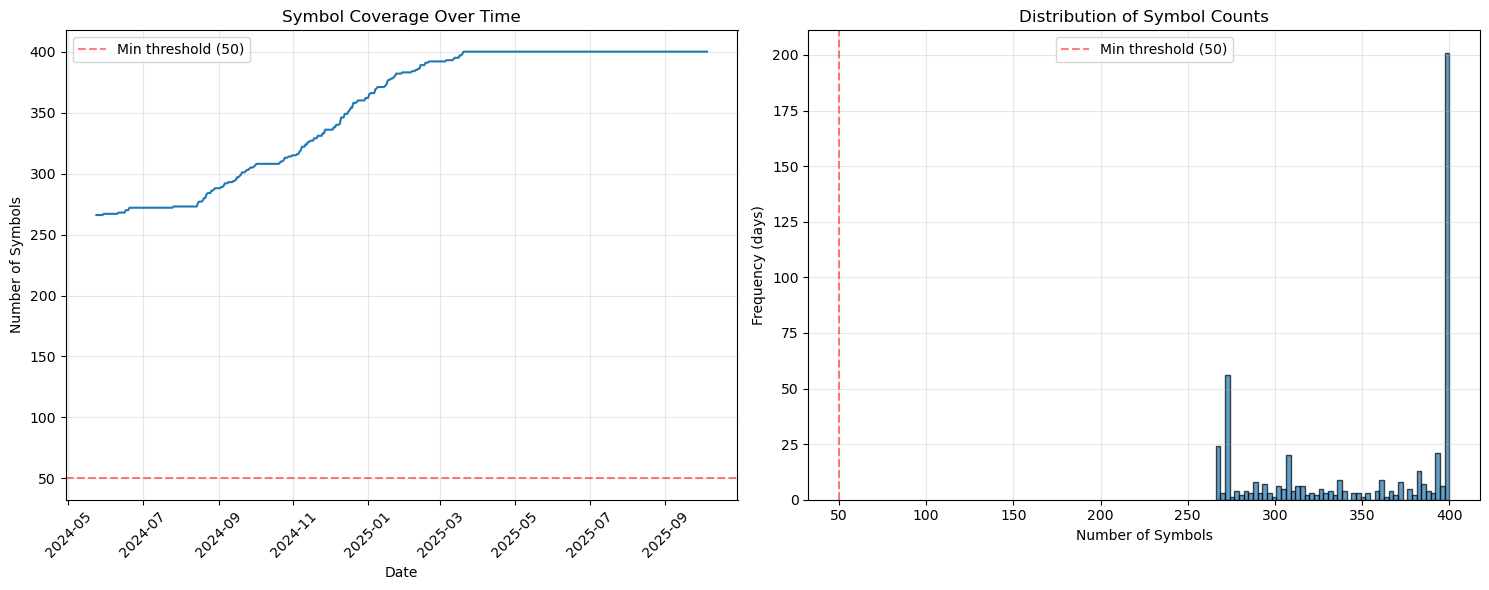

✓ Found 500 dates with ≥50 symbols
Best coverage period: 2024-05-24 to 2025-10-05
  Start: 266 symbols
  End: 400 symbols
  Average: 352.7 symbols

Overall date coverage:
  Earliest date: 2024-05-24 (266 symbols)
  Latest date: 2025-10-05 (400 symbols)
  Total trading days: 500
  Max symbols on any day: 400


In [8]:
# Count symbols per date
from collections import Counter

date_coverage = Counter()
for symbol, df in processed_data.items():
    for date in df.index:
        date_coverage[date] += 1

# Convert to DataFrame for analysis
coverage_df = pd.DataFrame(list(date_coverage.items()), columns=['date', 'num_symbols'])
coverage_df = coverage_df.sort_values('date')

# Plot histogram
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(coverage_df['date'], coverage_df['num_symbols'], linewidth=1.5)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Min threshold (50)')
plt.title('Symbol Coverage Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Symbols')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(coverage_df['num_symbols'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=50, color='r', linestyle='--', alpha=0.5, label='Min threshold (50)')
plt.title('Distribution of Symbol Counts')
plt.xlabel('Number of Symbols')
plt.ylabel('Frequency (days)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best period (>=50 symbols)
good_dates = coverage_df[coverage_df['num_symbols'] >= 50].sort_values('date')

if len(good_dates) > 0:
    print(f"✓ Found {len(good_dates)} dates with ≥50 symbols")
    print(f"Best coverage period: {good_dates.iloc[0]['date'].date()} to {good_dates.iloc[-1]['date'].date()}")
    print(f"  Start: {good_dates.iloc[0]['num_symbols']} symbols")
    print(f"  End: {good_dates.iloc[-1]['num_symbols']} symbols")
    print(f"  Average: {good_dates['num_symbols'].mean():.1f} symbols")
else:
    print("⚠ No dates with ≥50 symbols. Consider lowering threshold or extending data collection.")

# Show date range statistics
print(f"\nOverall date coverage:")
print(f"  Earliest date: {coverage_df.iloc[0]['date'].date()} ({coverage_df.iloc[0]['num_symbols']} symbols)")
print(f"  Latest date: {coverage_df.iloc[-1]['date'].date()} ({coverage_df.iloc[-1]['num_symbols']} symbols)")
print(f"  Total trading days: {len(coverage_df)}")
print(f"  Max symbols on any day: {coverage_df['num_symbols'].max()}")

## 4. Select Trading Universe

Select top 21 coins by volume:

In [9]:
from CoinTrading.strategy.portfolio import select_by_volume

# Get latest date
latest_date = max(df.index[-1] for df in processed_data.values())

# Select top 21 by volume
universe = select_by_volume(
    date=latest_date,
    data=processed_data,
    top_n=21,
    volume_metric='tp_volume'
)

print(f"Selected {len(universe)} coins for trading universe:")
for i, symbol in enumerate(universe, 1):
    print(f"{i:2d}. {symbol}")

Selected 21 coins for trading universe:
 1. BTCUSDT
 2. ETHUSDT
 3. SOLUSDT
 4. DOGEUSDT
 5. BNBUSDT
 6. XRPUSDT
 7. SUIUSDT
 8. ZECUSDT
 9. ADAUSDT
10. 1000PEPEUSDT
11. AVAXUSDT
12. LTCUSDT
13. LINKUSDT
14. ENAUSDT
15. FARTCOINUSDT
16. WLDUSDT
17. BCHUSDT
18. CELOUSDT
19. EIGENUSDT
20. 1000FLOKIUSDT
21. PENGUUSDT


## 5. Visualize BTC with Indicators

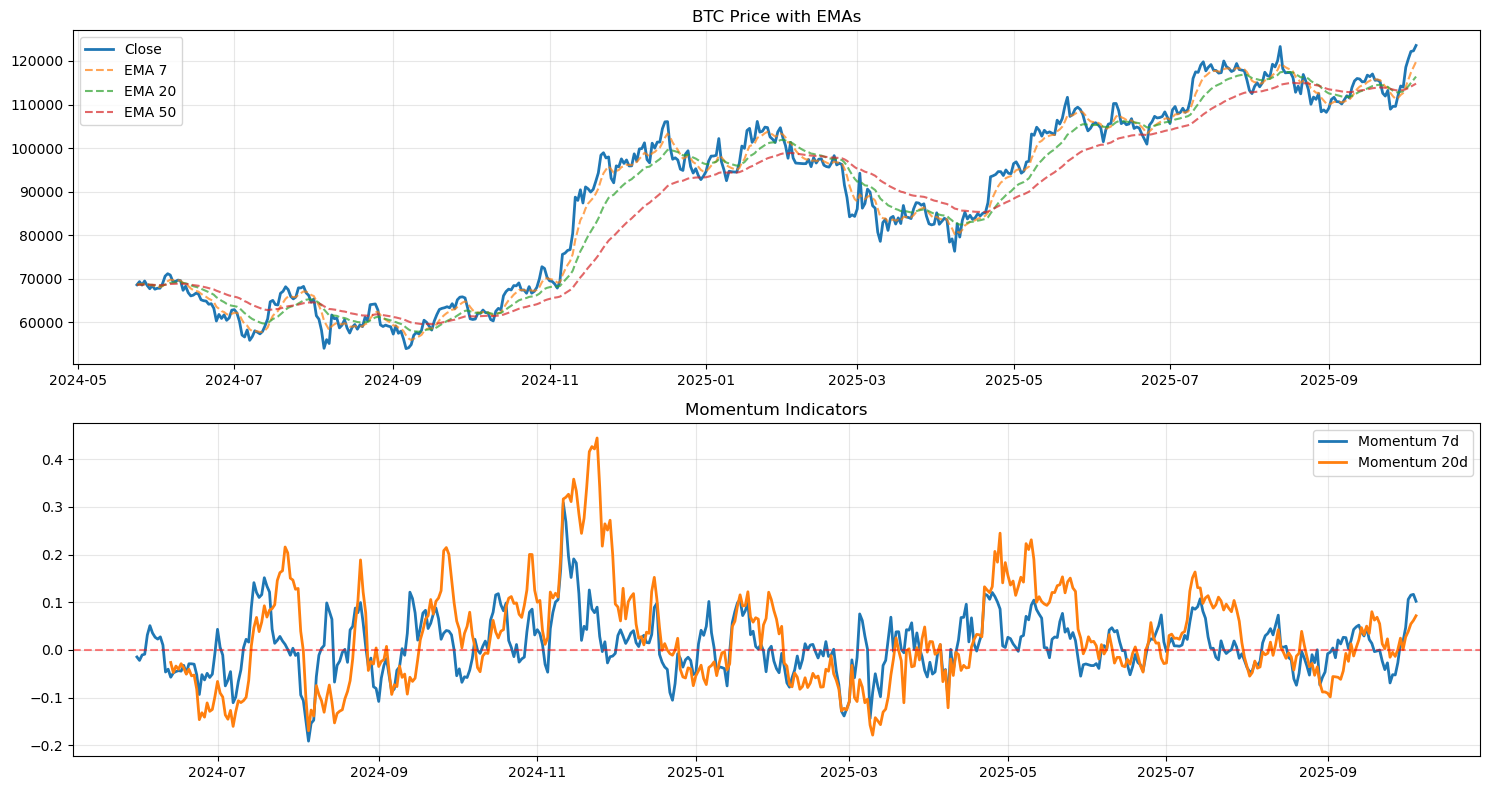

In [10]:
# Plot BTC with EMAs
btc = processed_data['BTCUSDT']

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.title('BTC Price with EMAs')
plt.plot(btc.index, btc['close'], label='Close', linewidth=2)
plt.plot(btc.index, btc['ema7'], '--', label='EMA 7', alpha=0.7)
plt.plot(btc.index, btc['ema20'], '--', label='EMA 20', alpha=0.7)
plt.plot(btc.index, btc['ema50'], '--', label='EMA 50', alpha=0.7)
#plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.title('Momentum Indicators')
plt.plot(btc.index, btc['mom7'], label='Momentum 7d', linewidth=2)
plt.plot(btc.index, btc['mom20'], label='Momentum 20d', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

✅ Successfully loaded and prepared data
- Implemented disk caching for faster loading
- Validated data quality (no NaN, sufficient history)
- Calculated all technical indicators (vectorized!)
- Selected trading universe (top 21 by volume)

**Key Improvements:**
- **RSI is now vectorized** (original used for-loop)
- **Fixed unsafe list iteration** bug
- **Disk caching** reduces API calls
- **Data validation** catches quality issues early

Next: [02_indicator_analysis.ipynb](02_indicator_analysis.ipynb)